## Bootcamp: Ciencia de Datos e Inteligencia Artificial
## Proyecto del Módulo 5: Aprendizaje profundo con redes neuronales
¡Hola, qué gusto que estés a un paso de obtener tu insignia del módulo 5! Aquí pondrás en juego las habilidades y conocimientos que has practicado a lo largo de estas semanas.

Lee el proyecto y revisa con cuidado cada una de las instrucciones. Procura plasmar todo tu potencial para que concluyas tu proyecto de manera exitosa.

¡Éxito!

# Objetivos
- Aplicarás los conocimientos que has adquirido sobre redes neuronales a contextos de la vida real.
- Puntuarás la precisión y valor de los modelos creados.
- Generarás gráficas que muestren la evolución de la precisión de los modelos.

> NOTA: El modelo se entrena en inglés, así que si quieres traducir estas noticias para comprenderlas mejor te puedes apoyar en herramientas como Google Translate, pero recuerda usar el texto en inglés para tu modelo.

# Parte 1

La propagación de *fake news* o noticias falsas se incrementó a partir de la pandemia por COVID-19. Estas son un problema alarmante porque hacen que las personas realicen actividades que normalmente no llevarían a cabo o que actúen de manera caótica. Un ejemplo es [-> esta noticia <-](https://drive.google.com/file/d/1PrfN83Fm1ib5mHYN6SULVe9CJVECUNn2/view?usp=share_link), en la que se relata cómo notas falsas acerca del daño que ocasiona la 5G al cuerpo provocaron que muchas personas en el Reino Unido quemaran torres de telecomunicaciones aun sin ser estas de 5G.

A ti, como persona experta en redes neuronales, te han encargado hacer un predector de noticias falsas para los *fact-checker* del mundo.

Para realizarlo, tienes a tu disposición el siguiente *dataset*: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

## Criterios de evaluación
- Utiliza Keras para entrenar un modelo de *Deep Learning* que ayude a detectar una noticia falsa. Recuerda hacer la limpieza de datos y el análisis exploratorio correspondiente para obtener el puntaje completo (2 puntos).
  - Pista: Revisa esto -> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- Determina el número de épocas a usar y explica por escrito por qué llegaste a esta conclusión. Si no hay explicación, no hay un punto (2 puntos).
- Calcula la precisión y pérdida del modelo (1 punto) y grafícalo a través de las épocas (1 punto).
- Prueba tu modelo con el texto de las siguientes noticias, tienes que ingresar y copiar su contenido. (2 puntos por ambas comprobaciones):
  - Noticia falsa: https://www.breitbart.com/politics/2016/09/10/exposed-fbi-director-james-comeys-clinton-foundation-connection/
  - Noticia verdadera: https://www.washingtonpost.com/sports/2022/11/14/world-cup-female-referee-kathryn-nesbitt/

**Importante**: Activa el tipo de entorno de ejecución con GPU en Google Colab, y elimina los dataframes que no uses luego de las transformaciones para librerar RAM.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from google.colab import drive
from sklearn.metrics import accuracy_score

In [2]:
drive.mount('/content/drive')
%run /content/drive/MyDrive/Ucamp/Functions.ipynb
DataFrame = pd.read_csv('/content/drive/MyDrive/Ucamp/Modulo5/WELFake_Dataset.csv')

DataFrame.head()

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
#Cortamos el dataset porque la capacidad de google coolab no permite llegar a los 40000 registros para esta red sin colapsar.
DataFrame = DataFrame.dropna(subset=['title', 'text'])
df = DataFrame.head(30000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 0 to 30211
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   title       30000 non-null  object
 2   text        30000 non-null  object
 3   label       30000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [4]:
df["label"][:5] #0 = fake and 1 = real

0    1
2    1
3    0
4    1
5    1
Name: label, dtype: int64

In [5]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Combina las columnas 'title' y 'text' para considerar todas las palabras
all_text = df['title'].str.cat(df['text'], sep=' ')

# Inicializa el Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(all_text)

# Calcula el número máximo de palabras
max_words = len(tokenizer.word_index) + 1

# Tokeniza y convierte a secuencias
sequences = tokenizer.texts_to_sequences(all_text)

# Calcula la longitud máxima de la secuencia
maxlen = max(len(seq) for seq in sequences)

# Asegurar que todas las secuencias tengan la misma longitud
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
df.loc[:, 'padded_sequences'] = list(padded_sequences) #version 2 padding

<ipython-input-5-916077fb80a7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'padded_sequences'] = list(padded_sequences) #version 2 padding


In [6]:
X = padded_sequences
y = np.array(df['label'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Modelo2

model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128, input_length=maxlen))
model2.add(Flatten())
model2.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model2.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model2.add(Dense(1, activation='sigmoid'))

#Compilar modelo 2

model2.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

Epochs = 5

batch_size = 32

# Entrenar modelo 2
history = model2.fit(X_train, y_train, epochs=Epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

# Evaluamos el modelo
loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print(f'Precisión en el conjunto de prueba: {acc*100:.2f}%')

Epoch 1/5
629/629 [==============================] - 65s 98ms/step - loss: 0.5957 - accuracy: 0.8608 - val_loss: 0.1554 - val_accuracy: 0.9405
Epoch 2/5
629/629 [==============================] - 46s 73ms/step - loss: 0.0954 - accuracy: 0.9673 - val_loss: 0.1293 - val_accuracy: 0.9537
Epoch 3/5
629/629 [==============================] - 46s 73ms/step - loss: 0.0458 - accuracy: 0.9864 - val_loss: 0.1520 - val_accuracy: 0.9541
Epoch 4/5
629/629 [==============================] - 47s 75ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.1849 - val_accuracy: 0.9521
Epoch 5/5
629/629 [==============================] - 45s 71ms/step - loss: 0.0077 - accuracy: 0.9971 - val_loss: 0.2750 - val_accuracy: 0.9463
Precisión en el conjunto de prueba: 94.63%


**5 epocas fueron las iniciales aunque tenia previsto probar con 10, 20 y 30 sin embargo el modelo con solo 5 epocas ya nos muestra un resultado del 95% de presicion por lo que no fue necesario utilizar mas, de esta manera tambien optimizamos el modelo y los recursos que tenemos**

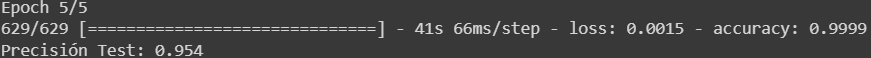

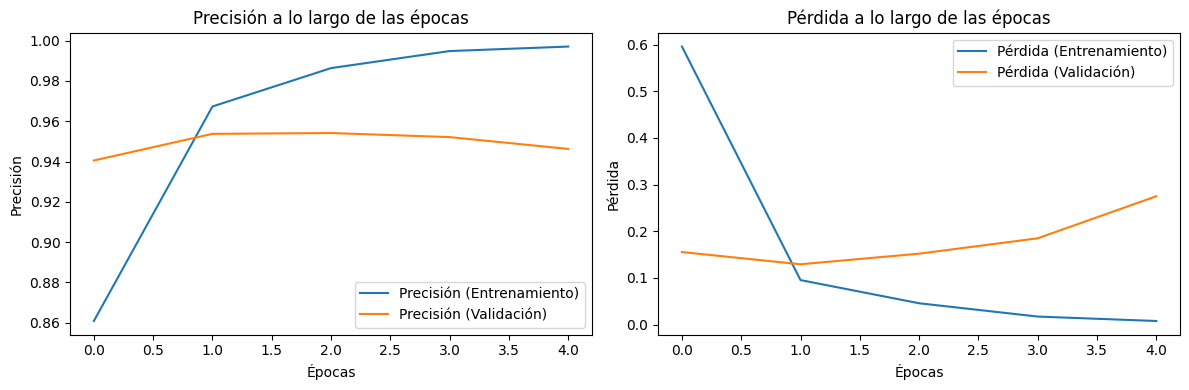

In [7]:
# Graficar precisión y pérdida a lo largo de las épocas
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión (Entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión (Validación)')
plt.title('Precisión a lo largo de las épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
plt.title('Pérdida a lo largo de las épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
#Dataset de prueba ya con los articulos añadidos
xlsx = "/content/drive/MyDrive/Ucamp/Modulo5/Prueba.xlsx"

Prueba = pd.read_excel(xlsx)
Prueba.head()

,title,text,label
0,Exposed: FBI Director James Comey’s Clinton Fo...,"WASHINGTON, D.C. — A review of FBI Director Ja...",0
1,"In Qatar, one of the World Cup’s first female ...",Kathryn Nesbitt had spent a decade balancing p...,1


In [9]:
# Tokenizar y procesar el nuevo conjunto de datos
all_text_new = Prueba['title'].str.cat(Prueba['text'], sep=' ')
sequences_new = tokenizer.texts_to_sequences(all_text_new)
padded_sequences_new = pad_sequences(sequences_new, maxlen=maxlen)

In [10]:
#realizar la prediccion del modelo
predictions = model2.predict(padded_sequences_new)

threshold = 0.5
s = (predictions > threshold).astype(int)

for i, prediction in enumerate(s):
    result = "real" if prediction == 1 else "falsa"
    result_real = "real" if Prueba["label"].values[i] == 1 else "falsa"
    print(f"Noticia {i + 1}: es {result_real} y la red predijo que era {result}")

1/1 [==============================] - 0s 92ms/step
Noticia 1: es falsa y la red predijo que era real
Noticia 2: es real y la red predijo que era falsa


# Parte 2
Se acerca el fin de año y con ello la necesidad de realizar los balances generales, estados financieros, etc. Una empresa te contrata para capturar manualmente todos sus recibos de ventas, solo que hay un pequeño problema: todos están hechos a mano, por lo que sería muy tardado ver recibo tras recibo y capturarlos de forma manual.

Sin embargo, recuerdas que aprendiste acerca de las redes neuronales convolucionales. Por ello, decides hacer un modelo que afronte este problema con Inteligencia Artificial y que convierta la escritura a mano en caracteres.

Tienes el *dataset* de dígitos escritos a mano de Mnist a tu disposición:
https://www.tensorflow.org/datasets/catalog/mnist , que puedes invocar de esta manera:


```python
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

```

## Criterios de evaluación
- Entrena el modelo utilizando Tensorflow y todas las capas que creas necesarias. Explica por qué elegiste esas capas. Si no hay explicación, se invalida un punto (2 puntos).
- Grafica la evolución de la pérdida y la precisión del entrenamiento y genera un conjunto de 10 predicciones con los mismos datos del *dataset* (2 puntos).


¡Éxito! Te vemos en el contenido del siguiente módulo.

In [11]:
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

(x_train1, y_train1), (x_test1, y_test1) = keras.datasets.mnist.load_data()

#Podemos ver que Y ya se encuentra en forma de vector por lo que no aplicamos el metodo .flatten
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [12]:
#X_train son imagenes de 2 dimensiones que contienen 60000 imagenes de 28x28 cada una, no tiene color porque esta en escala de grises
print(x_train1.shape)

(60000, 28, 28)


In [13]:
#Los valores unicos en y_train son numeros que corresponden a las imagenes
np.unique(y_train1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

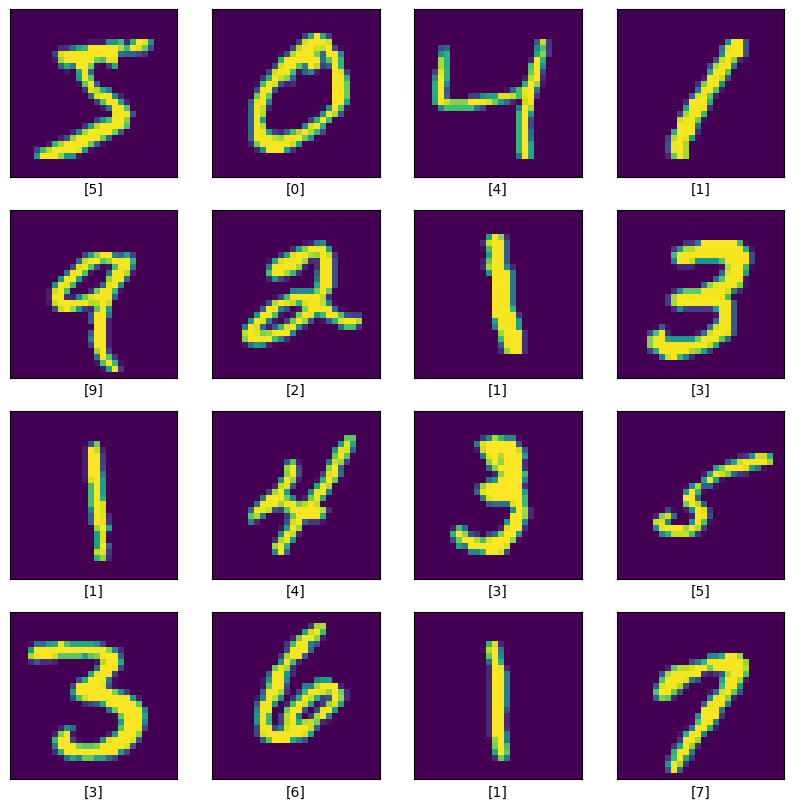

In [14]:
#Revisando las imagenes estas corresponden a diferentes numeros escritos a mano y y_train es el numero al que corresponde
plt.figure(figsize=(10, 10))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(x_train1[i])
  plt.xlabel([y_train1[i]])
  plt.xticks([])
  plt.yticks([])

In [15]:
#Convertimos los valores a flotantes
x_train1= x_train1.astype('float32')
x_test1= x_test1.astype('float32')

In [16]:
x_train1=x_train1 / 255.0
x_test1=x_test1 / 255.0

In [17]:
#Preparamos los datos con one hot encoder para que las etiquetas se conviertan en un vector binario y asi nos muestre el resultado en la posicion correspondiente
y_train1 = to_categorical(y_train1, 10) #el numero 10 son las respuestas posibles
y_test1 = to_categorical(y_test1, 10)

In [18]:
#Por ejemplo, la imagen 10 corresponde al numero 3
print(y_train1[10])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [19]:
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

(60000, 28, 28)
(60000, 10)
(10000, 28, 28)
(10000, 10)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

# Tenemos solo 3 dimensiones en nuestro x_train por ende tenemos que expandirlo para completar 4 dims
x_train1 = np.expand_dims(x_train1, axis=-1)
x_test1 = np.expand_dims(x_test1, axis=-1)

#Ajustamos las dimensiones de y_train e y_test para que coincidan con los datos de entrada
y_train1 = y_train1[:x_train1.shape[0]]
y_test1 = y_test1[:x_test1.shape[0]]

num_classes = 10
batch_size1 = 30
epochs1 = 25 #Los resultados posibles, utilizamos 15 epocas como numero incial

model1 = Sequential()
model1.add(Conv2D(128, 3, padding='same', input_shape=x_train1.shape[1:], activation='relu')) #Activacion relu porque son especiales para CNN(Covolucionales)
model1.add(Conv2D(128, 3, activation='relu'))
model1.add(MaxPooling2D()) #Con esta capa disminuimos el tamaño de 2x2 a 1x1
model1.add(Dropout(0.25)) #Regularizar 25% de los nodos

#model1.add(Conv2D(64, 3, padding='same', activation='relu'))
#model1.add(Conv2D(64, 3, activation='relu'))
#model1.add(MaxPooling2D())
#model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))


model1.summary()

model1.compile(optimizers.RMSprop(learning_rate=0.001), #0.001 el learn rate para hacer el modelo mas optimo
            loss='categorical_crossentropy', metrics=['acc'])

history = model1.fit(x_train1, y_train1,
                    batch_size= batch_size1,
                    epochs= epochs1,
                    validation_data= (x_test1, y_test1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 21632)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                692256    
                                                      

**Este es el resultado con 12 neuronas, 15 epocas y un batch size de 32**

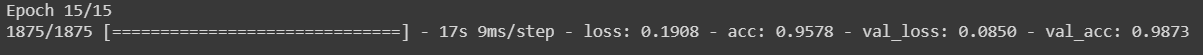

**Este es el resultado con 12 neuronas, 25 epocas y un batch size de 30**

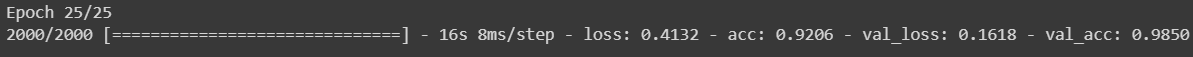

**Este es el resultado con 8 neuronas 25 epocas y un batch size de 30**
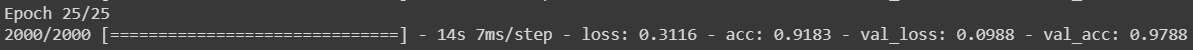

**Este es el resultado con 8 neuronas 30 epocas y un batch size de 32**

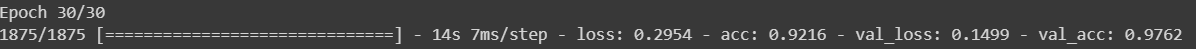

Una de las conclusiones a las que podemos llega es para esta cantidad de datos 8 neuronas con 1 filtro dropout al 25% y 1 filtro maxpooling 2d es suficiente para obtener un resultado del 97% de eficacia y una perdida de solo el 0.28 por lo que procedemos a usar el modelo de solo 8 neuronas, 25 epocas y un batch size de 30 (aunque no es el resultado mas alto es suficiente para optimizar el modelo y los recursos).

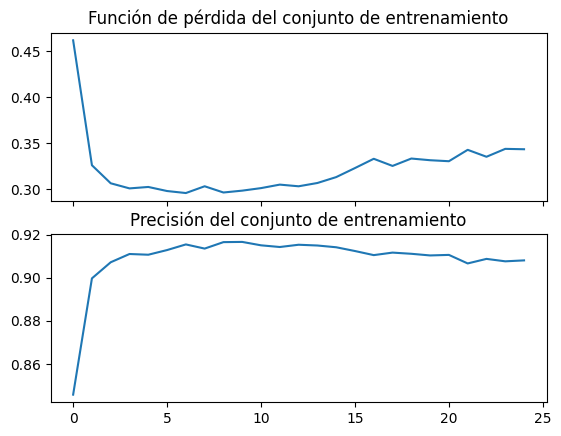

In [21]:
# Visualizar resultados para 8 neuronas, 25 epocas y batch size de 30
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(history.history['loss'])
ax1.set_title('Función de pérdida del conjunto de entrenamiento')
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
ax2.plot(history.history['acc'])
ax2.set_title('Precisión del conjunto de entrenamiento')

plt.setp(ax1.get_xticklabels(), visible=False)

plt.show()

1/1 [==============================] - 0s 200ms/step


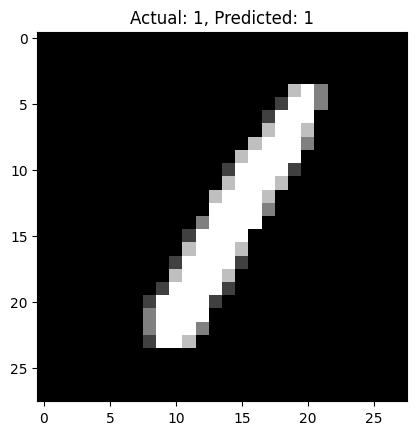

1/1 [==============================] - 0s 23ms/step


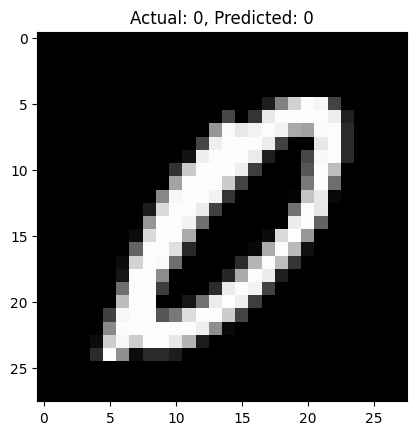

1/1 [==============================] - 0s 19ms/step


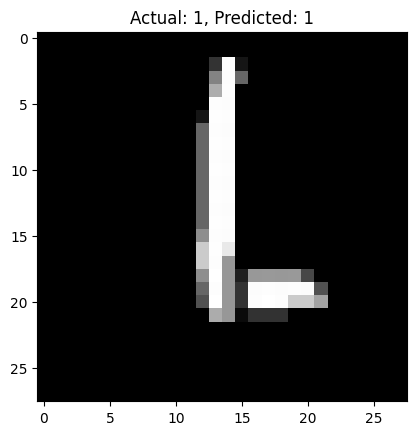

1/1 [==============================] - 0s 21ms/step


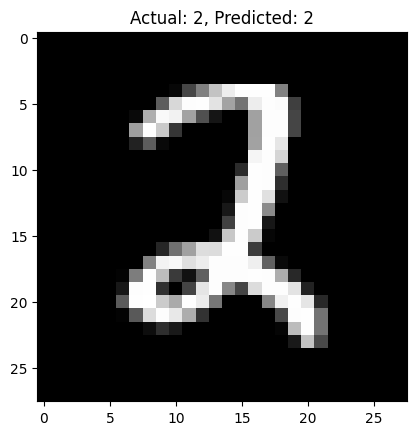

1/1 [==============================] - 0s 20ms/step


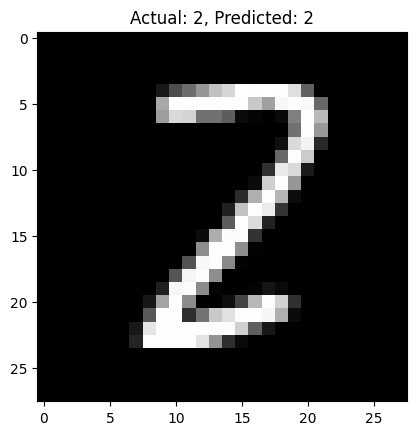

1/1 [==============================] - 0s 18ms/step


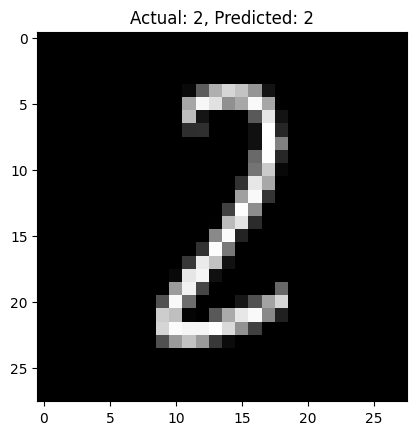

1/1 [==============================] - 0s 18ms/step


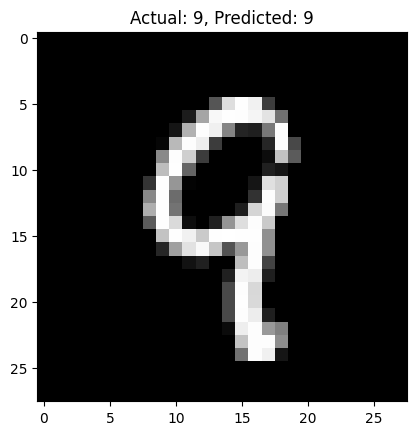

1/1 [==============================] - 0s 19ms/step


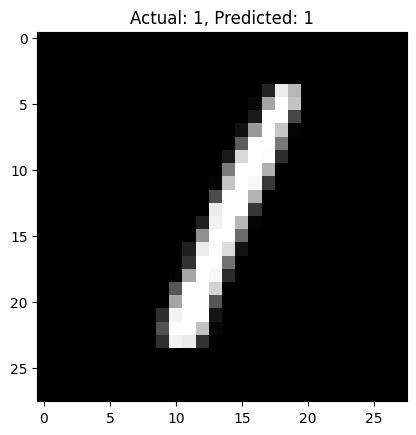

1/1 [==============================] - 0s 19ms/step


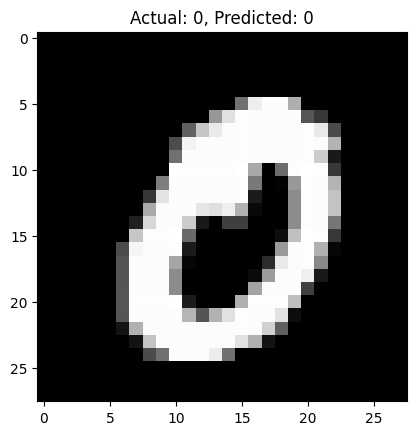

1/1 [==============================] - 0s 18ms/step


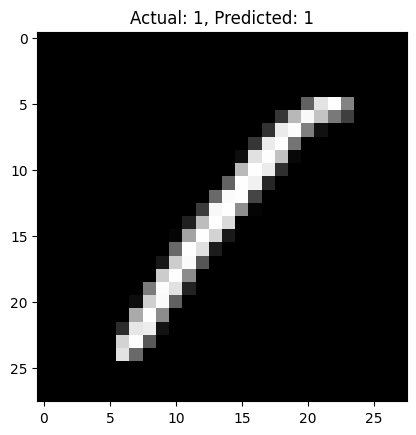

In [22]:
#Generamos una prueba con imagenes random con la linea de codigo random_indices = np.random.choice(len(x_test), num_images, replace=False)
Prueba = prueba_CNN(model1, x_test1, y_test1, num_images=10)